# Loyalty Market Test

Data is stored in a S3 bucket, I need to fetch it using a hadoop library and then start testing it.

# Data Gathering & Ingestion
Before making pipeline or analitycs work, data should be download to the saprk session and fix any issue concerning partitions management. As introduce in the following code:

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
s3_access_key = os.environ.get("S3_ACCESS_KEY")
s3_secret_key = os.environ.get("S3_SECRET_KEY")
CORES = 4 # Remember to use 2 cores for laptop work and 4 cores for local machine

ModuleNotFoundError: No module named 'dotenv'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Loyalty") \
    .config("spark.master", "local[{CORES}]") \
    .config("spark.executor.cores", "4") \
    .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:3.3.1") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.access.key", s3_access_key) \
    .config("spark.hadoop.fs.s3a.secret.key", s3_secret_key) \
    .getOrCreate()

In [3]:
# Location dataframe
df_loc = spark.read.format("csv").option("header", "true") \
        .load("s3a://data-test-202302/location.csv", header=True)
df_loc.show(5)

+------------------+------+----------------+----------+-----------+--------+---------+
|store_location_key|region|        province|      city|postal_code|  banner|store_num|
+------------------+------+----------------+----------+-----------+--------+---------+
|              1794|    NA|         ONTARIO|    LONDON|         NA|dc35b695|     1794|
|                42|    NA|         ONTARIO|   TORONTO|         NA|dc35b695|       42|
|              7218|    NA|         ALBERTA|SLAVE LAKE|         NA| 6e36648|     7218|
|              7196|    NA|BRITISH COLUMBIA|  VICTORIA|         NA| 6e36648|     7196|
|              7167|    NA|BRITISH COLUMBIA|    SURREY|         NA| 6e36648|     7167|
+------------------+------+----------------+----------+-----------+--------+---------+
only showing top 5 rows



In [4]:
# Product dataframe
df_prod = spark.read.format("csv").option("header", "true") \
        .load("s3a://data-test-202302/product.csv", header=True)
df_prod.show(5)

+-----------+---+----------+---------+----------------+----------+--------+
|product_key|sku|       upc|item_name|item_description|department|category|
+-----------+---+----------+---------+----------------+----------+--------+
| 7652613339|  0|7652613339|   324168|              NA|  651b1068|8312aed6|
| 1810063322|  0|1810063322|   276973|              NA|  651b1068|7aaa7a34|
| 5274585486|  0|5274585486|   794396|              NA|  c81ba571|54ea8364|
| 6978362094|  0|6978362094|   510386|              NA|  b947a4a9| 382cf3a|
| 6978396053|  0|6978396053|   120105|              NA|  b947a4a9| 382cf3a|
+-----------+---+----------+---------+----------------+----------+--------+
only showing top 5 rows



# Prepare & Cleanse the data in memory

Clean first partitions

In [5]:
# Trans fact dataframe: When there's multiples files with the same schema and name, put it on
# a folder and download it as a single dataframe. Tran_sac is a dataframe created by 10 csv  
df_trans = spark.read.format("csv").option("header", "true") \
        .load("s3a://data-test-202302/trans_fact/*", header=True)
df_trans.show(5)

+-------------+----------+------------------+---------------+-----+-----+--------------------+
|collector_key|  trans_dt|store_location_key|    product_key|sales|units|           trans_key|
+-------------+----------+------------------+---------------+-----+-----+--------------------+
|           -1|2015-10-28|              6973|999999999999513| 0.00|    1|31575569731182201...|
|           -1|2015-07-24|              6973|    77105810883| 8.53|    1|31216969731182201...|
| 141178981825|2015-12-14|              6973|    30041060552|11.55|    1|31755569731182201...|
|           -1|2015-04-10|              6973|999999999999142| 0.00|    1|30763169731182201...|
| 139518403300|2015-10-14|              6973|999999999999513| 0.00|    1|31520469731182201...|
+-------------+----------+------------------+---------------+-----+-----+--------------------+
only showing top 5 rows



## Understand work around partitions
To use the most of cores, partitions must be in multiples of number of cores in order to take the most advantage of processing power. 

**- On Laptop** The number of partitions processs by a core would be 2.

**- On Local machine** The number of partitions processs by a core would be just one.

As its expected, on laptop it would take more time to process data

TODO Show processing times and analyse spark UI

In [6]:
print("Number of partitions in location file: ",df_loc.rdd.getNumPartitions())
print("Number of partitions in production file: ",df_prod.rdd.getNumPartitions())
print("Number of partitions in transactional files: ",df_trans.rdd.getNumPartitions())

Number of partitions in location file:  1
Number of partitions in production file:  4
Number of partitions in transactional files:  4



## Skewing data Issues
As we can see, Partition 3 shown in product and transactional dataframes is uneven compared to others partitions.

In [7]:
partition_sizes_prod = df_prod.rdd.mapPartitions(lambda partition: [sum(map(len, partition))]).collect()
print("Partitions in product file")
for i, size in enumerate(partition_sizes_prod):
    print(f"Partition {i}: {size/104857} MB")

partition_sizes_trans = df_trans.rdd.mapPartitions(lambda partition: [sum(map(len, partition))]).collect()
print("Partitions in transaction files")
for i, size in enumerate(partition_sizes_trans):
    print(f"Partition {i}: {size/104857} MB")

Partitions in product file
Partition 0: 11.01880656513156 MB
Partition 1: 11.032692142632348 MB
Partition 2: 11.02428068703091 MB
Partition 3: 6.867753225821834 MB
Partitions in transaction files
Partition 0: 4.00545504830388 MB
Partition 1: 4.00545504830388 MB
Partition 2: 4.00545504830388 MB
Partition 3: 1.3351516827679601 MB


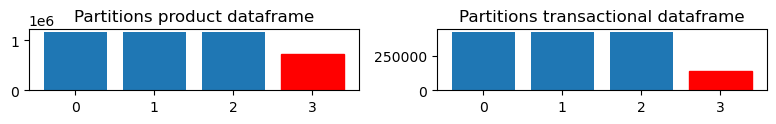

In [8]:
import matplotlib.pyplot as plt

plot, (part_sizes_prod, part_sizes_trans) = plt.subplots(1, 2, figsize=(8, 1.5))

part_sizes_prod.bar(range(len(partition_sizes_prod)), partition_sizes_prod)[-1].set_color('r')
part_sizes_trans.bar(range(len(partition_sizes_trans)), partition_sizes_trans)[-1].set_color('r')
part_sizes_prod.set_title('Partitions product dataframe')
part_sizes_trans.set_title('Partitions transactional dataframe')
plot.tight_layout()
plot.show()

In order to fix it, repartition command would be used to unskew partitions. However, this won't be necessary in a normal pipeline given the small amount of data worked here because it won't be worth it to spend the computing power in this task.

In [9]:
df_prod_r = df_prod.repartition(4)
df_trans_r = df_trans.repartition(4)
partition_sizes_prod_r = df_prod_r.rdd.mapPartitions(lambda partition: [sum(map(len, partition))]).collect()
print("Partitions in product file")
for i, size in enumerate(partition_sizes_prod_r):
    print(f"Partition {i}: {size/104857} MB")

partition_sizes_trans_r = df_trans_r.rdd.mapPartitions(lambda partition: [sum(map(len, partition))]).collect()
print("Partitions in transaction files")
for i, size in enumerate(partition_sizes_trans_r):
    print(f"Partition {i}: {size/104857} MB")

Partitions in product file
Partition 0: 9.985866465758127 MB
Partition 1: 9.985999980926405 MB
Partition 2: 9.985866465758127 MB
Partition 3: 9.985799708173989 MB
Partitions in transaction files
Partition 0: 3.3378792069199004 MB
Partition 1: 3.3378792069199004 MB
Partition 2: 3.3378792069199004 MB
Partition 3: 3.3378792069199004 MB


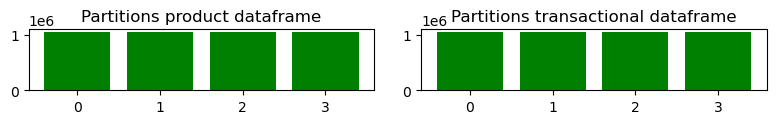

In [10]:
plot, (part_sizes_prod, part_sizes_trans) = plt.subplots(1, 2, figsize=(8, 1.5))
part_sizes_prod.bar(range(len(partition_sizes_prod_r)), partition_sizes_prod_r, color='g')
part_sizes_trans.bar(range(len(partition_sizes_trans_r)), partition_sizes_prod_r, color='g')
part_sizes_prod.set_title('Partitions product dataframe')
part_sizes_trans.set_title('Partitions transactional dataframe')
plot.tight_layout()
plot.show()

## Cleanse data from Null records
Replacing any null sales and null units with zero

In [11]:
from pyspark.sql.functions import when, col

df_trans = df_trans.withColumn("sales", when(col("sales").isNull(), 0).otherwise(col("sales")))
df_trans = df_trans.withColumn("units", when(col("units").isNull(), 0).otherwise(col("units")))
df_trans.show(2)

+-------------+----------+------------------+---------------+-----+-----+--------------------+
|collector_key|  trans_dt|store_location_key|    product_key|sales|units|           trans_key|
+-------------+----------+------------------+---------------+-----+-----+--------------------+
|           -1|2015-10-28|              6973|999999999999513| 0.00|    1|31575569731182201...|
|           -1|2015-07-24|              6973|    77105810883| 8.53|    1|31216969731182201...|
+-------------+----------+------------------+---------------+-----+-----+--------------------+
only showing top 2 rows



In [12]:
df_trans_r = df_trans_r.withColumn("sales", when(col("sales").isNull(), 0).otherwise(col("sales")))
df_trans_r = df_trans_r.withColumn("units", when(col("units").isNull(), 0).otherwise(col("units")))
df_trans_r.show(2)

+-------------+---------------+------------------+-----------+-----+-----+--------------------+
|collector_key|       trans_dt|store_location_key|product_key|sales|units|           trans_key|
+-------------+---------------+------------------+-----------+-----+-----+--------------------+
|         1396|999999999999513|                -1| 2015-08-19| 0.00|    1|61457813961182201...|
|         8142|999999999999513|                -1| 2015-10-13| 0.00|    1|42785814211822015...|
+-------------+---------------+------------------+-----------+-----+-----+--------------------+
only showing top 2 rows



In [13]:
df_trans = df_trans.withColumn("col1_is_zero", when(col("sales") == 0, False).otherwise(True))
df_trans.show(2)

+-------------+----------+------------------+---------------+-----+-----+--------------------+------------+
|collector_key|  trans_dt|store_location_key|    product_key|sales|units|           trans_key|col1_is_zero|
+-------------+----------+------------------+---------------+-----+-----+--------------------+------------+
|           -1|2015-10-28|              6973|999999999999513| 0.00|    1|31575569731182201...|       false|
|           -1|2015-07-24|              6973|    77105810883| 8.53|    1|31216969731182201...|        true|
+-------------+----------+------------------+---------------+-----+-----+--------------------+------------+
only showing top 2 rows



In [14]:
df_trans_r = df_trans_r.withColumn("col1_is_zero", when(col("sales") == 0, False).otherwise(True))
df_trans_r.show(2)

+-------------+---------------+------------------+-----------+-----+-----+--------------------+------------+
|collector_key|       trans_dt|store_location_key|product_key|sales|units|           trans_key|col1_is_zero|
+-------------+---------------+------------------+-----------+-----+-----+--------------------+------------+
|         1396|999999999999513|                -1| 2015-08-19| 0.00|    1|61457813961182201...|       false|
|         8142|999999999999513|                -1| 2015-10-13| 0.00|    1|42785814211822015...|       false|
+-------------+---------------+------------------+-----------+-----+-----+--------------------+------------+
only showing top 2 rows

